In [ ]:
'''Not a tutorial.'''

In [1]:
# import corpus
from nltk.corpus import gutenberg
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [10]:
# preprocessing corpus -> getting rid of punctuation
import os
import string
from collections import defaultdict

def depunctuationize(path, new_path, unwanted_char=string.punctuation):
    file = open(path, 'r')
    new_file = open(new_path, 'w')
    for line in file:
        new_line = []
        for char in line:
            if char not in unwanted_char:
                new_line.append(char)
        new_file.write(''.join(new_line))
    file.close()
    new_file.close()

    
def get_frequencies(path):
    frequencies = defaultdict(int)
    file = open(path, 'r')
    for line in file:
        line = line.lower().split()
        for token in line:
            frequencies[token] += 1
    file.close()
    return frequencies
    

def merge_frequencies(list_dicts):
    # get the global frequency based on frequencies on parts of the corpus
    global_dict = {}
    for d in list_dicts:
        for key in d:
            if key in global_dict:
                global_dict[key] += d[key]
            else:
                global_dict[key] = d[key]
    return global_dict
    
    
def keep_non_unique_tokens(path, new_path, frequency):
    file = open(path, 'r')
    new_file = open(new_path, 'w')
    for line in file:
        new_line = []
        line = line.lower().split()
        for token in line:
            if frequency[token] > 1:
                new_line.append(token)
        new_file.write(' '.join(new_line)+'\n')
    file.close()
    new_file.close()

    
def preprocessing_txt(path, unwanted_char=string.punctuation, keep_unique=False):
    # get rid of the punctuation and the once used words for a single .txt file
    interm_path = path + '_no_punct.txt'
    final_path = path + '_preprocessed.txt'
    depunctuationize(path+'.txt', interm_path, unwanted_char)
    if not keep_unique:
        if freq == None:
            freq = get_frequencies(interm_path)
        keep_non_unique_tokens(interm_path, final_path, freq)
        os.remove(interm_path)

def preprocessing_directory(dir_path, unwanted_char=string.punctuation):
    # same thing than above, but for an entire file of .txt
    # different function than above to have a common frequencies dictionary
    global_freq = {}
    for filename in os.listdir(dir_path):
        if '.txt' in filename:
            print(filename)
            interm_path = dir_path + filename[:-4] + '_no_punct.txt'
            depunctuationize(dir_path+filename, interm_path, unwanted_char)
            global_freq = merge_frequencies([global_freq, get_frequencies(interm_path)])
    # remove words such that global freq = 1
    for filename in os.listdir(dir_path):
        if '.txt' in filename:
            if '_no_punct' in filename:
                final_path = dir_path + filename[:-13] + '_preprocessed.txt'
                keep_non_unique_tokens(dir_path+filename, final_path, global_freq)
    # remove intermediate files
    for filename in os.listdir(dir_path):
        if '_no_punct' in filename:
            os.remove(dir_path+filename)

In [13]:
# preprocessing the 'gutenberg' texts

dir_path = "/Users/Boulot/nltk_data/corpora/gutenberg/"
unwanted_char = string.punctuation

preprocessing_directory(dir_path)

blake-poems.txt
chesterton-thursday_no_punct.txt
carroll-alice.txt
carroll-alice_no_punct.txt
whitman-leaves.txt
melville-moby_dick_no_punct.txt
milton-paradise_no_punct.txt
milton-paradise.txt
bible-kjv.txt
whitman-leaves_no_punct.txt
bible-kjv_no_punct.txt
austen-persuasion_no_punct.txt
edgeworth-parents_no_punct.txt
chesterton-ball_no_punct.txt
austen-persuasion.txt
melville-moby_dick.txt
edgeworth-parents.txt
chesterton-thursday.txt
burgess-busterbrown.txt
burgess-busterbrown_no_punct.txt
blake-poems_no_punct.txt
austen-emma.txt
chesterton-brown.txt
shakespeare-hamlet.txt
austen-sense.txt
shakespeare-macbeth.txt
bryant-stories.txt


In [255]:
## tokenize
from smart_open import open  # for transparently opening remote files


class TokenizedCorpus:
    # set of tokenized documents
    def __init__(self, path, stoplist):
        self.path = path
        self.stoplist = stoplist
        
    def __iter__(self):
        # assume docs separated by two empty lines, tokens separated by whitespace
        doc = []
        line_empty = False
        prev_line_empty = False
        for line in open(self.path, 'r'):
            prev_line_empty = line_empty
            line_empty = (line == '\n' or line == ' \n')
            if line_empty and prev_line_empty: # end of document
                yield doc
                doc = []
                line_empty = False
                prev_line_empty = False
            else:
                doc.extend([word for word in line.lower().split() if word not in self.stoplist])
    
    def get(self, i):
        # get the ith document
        j = 0
        for doc in self:
            if j == i:
                return doc
            j += 1
        raise IndexError("Index out of range")
    
    def display(self, i, cap = 10):
        # display the doc i, if i == None, displays every doc (caped by cap)
        if i != None:
            doc = self.get(i)
            print(doc)
        else:
            j = 0
            for doc in self:
                if j >= cap:
                    break
                print(doc)
                print("")
                j += 1

In [268]:
from gensim import corpora


# defining the corpus
path = "/Users/Boulot/nltk_data/corpora/gutenberg/blake-poems_preprocessed.txt"
stoplist = set('for a of the and to in'.split())
blek = TokenizedCorpus(path, stoplist)

blek.display(None) # the ten first as cap=10 by default
blek.display(4) # the fourth element

# create frequency dictionary
frequency = defaultdict(int)
for poem in blek:
    for token in poem:
        frequency[token] += 1

# getting rid of words with frequency = 1
# not done yet => do it during the preprocessing



dictionary = corpora.Dictionary(blek)
bow_corpus = [dictionary.doc2bow(poem) for poem in blek]


n_words = len(dictionary)
n_docs = len(bow_corpus)

print(n_words, n_docs)
print(dictionary)
print(bow_corpus[57])
i = 347
print(dictionary[i])
print(frequency[dictionary[i]])

['by', 'william', 'blake']

['songs', 'innocence', 'experience', 'book', 'thel']

['songs', 'innocence']

['introduction', 'piping', 'down', 'valleys', 'wild', 'piping', 'songs', 'pleasant', 'on', 'cloud', 'i', 'saw', 'child', 'he', 'laughing', 'said', 'me', 'pipe', 'song', 'lamb', 'so', 'i', 'piped', 'with', 'merry', 'cheer', 'piper', 'pipe', 'that', 'song', 'again', 'so', 'i', 'piped', 'he', 'wept', 'hear', 'thy', 'pipe', 'thy', 'happy', 'pipe', 'sing', 'thy', 'songs', 'happy', 'cheer', 'so', 'i', 'sang', 'again', 'while', 'he', 'wept', 'with', 'joy', 'hear', 'piper', 'sit', 'thee', 'down', 'book', 'that', 'all', 'may', 'read', 'so', 'he', 'from', 'my', 'sight', 'i', 'hollow', 'i', 'made', 'i', 'water', 'i', 'my', 'happy', 'songs', 'every', 'child', 'may', 'joy', 'hear']

['shepherd', 'how', 'sweet', 'is', 'sweet', 'lot', 'from', 'morn', 'evening', 'he', 'he', 'shall', 'follow', 'his', 'sheep', 'all', 'day', 'his', 'tongue', 'shall', 'be', 'filled', 'with', 'praise', 'he', 'hears', '

In [269]:
## tf-idf
from gensim import models

tfidf = models.TfidfModel(bow_corpus)

tfidf_corpus = tfidf[bow_corpus]
print(tfidf_corpus[57])

[(1, 0.020937002648871654), (7, 0.2097039050393787), (9, 0.050594913882529374), (12, 0.20132367328859715), (13, 0.06568343800198712), (14, 0.03284171900099356), (15, 0.07672142969714377), (17, 0.05754107227285782), (18, 0.030981509284789606), (20, 0.07501173450362913), (23, 0.037385233976390514), (26, 0.04026473465771943), (27, 0.04006853923558352), (29, 0.047866122528491296), (30, 0.046472263927184405), (37, 0.03284171900099356), (43, 0.02643799430939266), (45, 0.06465168448206954), (46, 0.050347675068437195), (47, 0.07201023351869577), (48, 0.043788958667991415), (49, 0.10947239666997853), (51, 0.027812210961174307), (53, 0.010947239666997854), (55, 0.02003426961779176), (57, 0.043788958667991415), (58, 0.04026473465771943), (62, 0.046472263927184405), (64, 0.048332473643388364), (65, 0.046472263927184405), (69, 0.03495065083989645), (73, 0.07931398292817798), (77, 0.03284171900099356), (78, 0.02003426961779176), (79, 0.020937002648871654), (82, 0.03495065083989645), (83, 0.022913770

In [270]:
# similarity
from gensim import similarities

index = similarities.Similarity(None, tfidf_corpus, n_words)

sentence = "The shepherd stays humble".lower().split()
bow_sentence = dictionary.doc2bow(sentence)
tfidf_sentence = tfidf[bow_sentence]

for (word_id, count) in bow_sentence:
    print(dictionary[word_id])

sims = index[tfidf_sentence]
for ind, sim in enumerate(sims):
    if sim > 0:
        print(sim)
        blek.display(ind)

shepherd
humble
0.37367126
['shepherd', 'how', 'sweet', 'is', 'sweet', 'lot', 'from', 'morn', 'evening', 'he', 'he', 'shall', 'follow', 'his', 'sheep', 'all', 'day', 'his', 'tongue', 'shall', 'be', 'filled', 'with', 'praise', 'he', 'hears', 'lambs', 'innocent', 'call', 'he', 'hears', 'tender', 'he', 'is', 'while', 'they', 'are', 'peace', 'they', 'know', 'when', 'their', 'shepherd', 'is', 'nigh']
0.12251365
['lily', 'modest', 'rose', 'forth', 'thorn', 'humble', 'sheep', 'horn', 'while', 'lily', 'white', 'shall', 'love', 'delight', 'nor', 'thorn', 'nor', 'her', 'beauty', 'bright']
0.057290953
['thel', 'i', 'led', 'round', 'their', 'sunny', 'flocks', 'all', 'but', 'she', 'sought', 'secret', 'air', 'fade', 'away', 'like', 'morning', 'beauty', 'from', 'her', 'mortal', 'day', 'down', 'by', 'river', 'her', 'soft', 'voice', 'is', 'heard', 'thus', 'her', 'gentle', 'like', 'morning', 'dew', 'o', 'life', 'this', 'our', 'spring', 'why', 'fades', 'water', 'why', 'fade', 'these', 'children', 'spring

In [271]:
# similarity between texts
from gensim import similarities

index = similarities.Similarity(None, tfidf_corpus, n_words)

doc = blek.get(4)
bow_doc = dictionary.doc2bow(doc)
tfidf_doc = tfidf[bow_doc]

sims = index[tfidf_doc]
for ind, sim in enumerate(sims):
    print(ind, sim)

0 0.0
1 0.0
2 0.0
3 0.0606424
4 1.0000001
5 0.049167022
6 0.0848001
7 0.09171728
8 0.039344303
9 0.09509425
10 0.031718038
11 0.078221545
12 0.081221506
13 0.110544555
14 0.067438565
15 0.10054423
16 0.101588465
17 0.07076665
18 0.010695553
19 0.06708874
20 0.116916604
21 0.074503176
22 0.10441844
23 0.0
24 0.05040294
25 0.005715925
26 0.009046076
27 0.0010536622
28 0.063303195
29 0.065771334
30 0.15659653
31 0.07951826
32 0.042688463
33 0.007608851
34 0.030463643
35 0.08499956
36 0.03633574
37 0.019500798
38 0.03433485
39 0.061760068
40 0.05546757
41 0.047544166
42 0.017341038
43 0.082638755
44 0.0
45 0.026236866
46 0.0926003
47 0.08034138
48 0.12031346
49 0.0610744
50 0.11965755
51 0.0
52 0.0052366997
53 0.0
54 0.0
55 0.049948364
56 0.0
57 0.0897918
58 0.0
59 0.08574817
60 0.0
61 0.068510294
62 0.0
63 0.030239183


In [260]:
def get_component(tfidf_doc, i):
    # sparse representation supposed for tfidf_doc
    for (j, score) in tfidf_doc:
        if j == i:
            return score
    return 0

379 flew
131 little
23


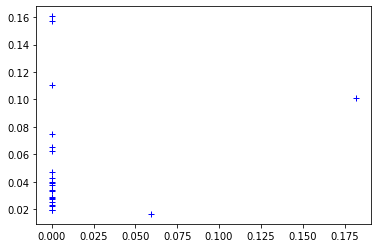

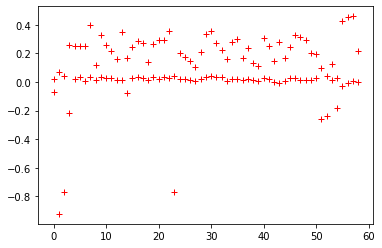

In [262]:
# ploting docs in a subspace of the wordspace
from numpy import random as rd
import matplotlib.pyplot as plt


# subspace generated by two random words
#w1, w2 = rd.randint(0, n_words, 2)
print(w1, dictionary[w1])
print(w2, dictionary[w2])

x1 = []
x2 = []
for doc in tfidf_corpus:
    c1 = get_component(doc, w1)
    c2 = get_component(doc, w2)
    if (c1, c2) != (0,0):
        x1.append(c1)
        x2.append(c2)

print(len(x1))

plt.plot(x1, x2, 'b+')
plt.show()


# using LSI

lsi_model = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=2)
lsi_corpus = lsi_model[tfidf_corpus]

X = [(doc[0][1], doc[1][1]) for doc in lsi_corpus]
plt.plot(X, 'r+')
plt.show()

In [18]:
### Word2Vec

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

#print(common_texts)

model = Word2Vec(sentences=common_texts, window=5,
                min_count=1, workers=4)
model.save("word2vec.model")
model.vector_size # mais quel fdp

100

In [21]:
model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 3)

In [30]:
vector = model.wv['computer']
print(vector)

human = model.wv['human'] # human is in common_texts
print(human)

sims = model.wv.most_similar('computer', topn=10)
sims

[ 2.5743213e-03 -3.1757259e-03 -3.8374278e-03  1.5507556e-03
  6.4108812e-04  1.7148728e-03 -1.9206967e-04 -3.2420915e-03
  3.6351059e-03  1.5639565e-03  2.6636592e-03 -9.4849005e-04
  4.0578973e-03  3.4028683e-03 -4.7345264e-03  7.8193651e-04
  2.5676009e-03 -5.8642740e-04  3.8515439e-03 -2.7970613e-03
 -3.1271391e-03 -4.1154246e-03 -2.5386242e-03  4.0929983e-03
 -2.6059090e-03 -4.5898478e-03 -4.2183897e-03  4.3383581e-03
 -9.9987548e-04  3.9746449e-03 -1.8275446e-03 -4.9976218e-03
 -3.4079268e-03  3.1054837e-03  3.5185162e-03 -2.5241575e-03
  1.5237235e-03 -3.9041613e-03 -4.2068758e-03 -4.0560979e-03
  1.1805405e-03 -2.8751926e-03 -3.5831386e-03  1.3338398e-03
  3.7080343e-03  4.5879721e-03  3.5969331e-03  2.3906520e-03
  1.7619601e-03  6.6102674e-04 -3.4687323e-03 -4.3703690e-03
  2.2459121e-03  4.3088277e-03 -2.9605956e-04 -3.6732343e-03
 -7.8329474e-05 -1.5894239e-03  1.7832357e-03 -1.1443011e-03
 -4.3626134e-03 -3.3613929e-04  1.3246055e-03  1.3056709e-03
 -9.1148767e-04 -1.18318

[('system', 0.22482100129127502),
 ('human', 0.08348163962364197),
 ('minors', 0.07421281933784485),
 ('graph', 0.06919119507074356),
 ('eps', -0.03306104242801666),
 ('trees', -0.03586779534816742),
 ('time', -0.039178527891635895),
 ('interface', -0.07458487153053284),
 ('survey', -0.09920290112495422),
 ('user', -0.11608728766441345)]

In [41]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load('word2vec.wordvectors', mmap='r')

wv['computer']

array([ 2.5743213e-03, -3.1757259e-03, -3.8374278e-03,  1.5507556e-03,
        6.4108812e-04,  1.7148728e-03, -1.9206967e-04, -3.2420915e-03,
        3.6351059e-03,  1.5639565e-03,  2.6636592e-03, -9.4849005e-04,
        4.0578973e-03,  3.4028683e-03, -4.7345264e-03,  7.8193651e-04,
        2.5676009e-03, -5.8642740e-04,  3.8515439e-03, -2.7970613e-03,
       -3.1271391e-03, -4.1154246e-03, -2.5386242e-03,  4.0929983e-03,
       -2.6059090e-03, -4.5898478e-03, -4.2183897e-03,  4.3383581e-03,
       -9.9987548e-04,  3.9746449e-03, -1.8275446e-03, -4.9976218e-03,
       -3.4079268e-03,  3.1054837e-03,  3.5185162e-03, -2.5241575e-03,
        1.5237235e-03, -3.9041613e-03, -4.2068758e-03, -4.0560979e-03,
        1.1805405e-03, -2.8751926e-03, -3.5831386e-03,  1.3338398e-03,
        3.7080343e-03,  4.5879721e-03,  3.5969331e-03,  2.3906520e-03,
        1.7619601e-03,  6.6102674e-04, -3.4687323e-03, -4.3703690e-03,
        2.2459121e-03,  4.3088277e-03, -2.9605956e-04, -3.6732343e-03,
      

In [46]:
for word in model.wv.vocab:
    print(word)

human
interface
computer
survey
user
system
response
time
eps
trees
graph
minors
